# GPR to predict the number of atoms


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
from sklearn.metrics import r2_score
import sklearn.gaussian_process as gp

In [17]:
df = pd.read_csv('mu_cn10000.csv')


In [18]:
def GPR_get_CN(features, labels, percent_test):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=percent_test, random_state = 42)
    # Import the model we are using
    kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
    gpr = model.fit(train_features, train_labels)
    params = model.kernel_.get_params()
    pred_labels, std = model.predict(test_features, return_std=True)
    MSE = ((pred_labels-test_labels)**2).mean()
    RMSE = MSE**(1/2)
    print('MSE = ', MSE)
    print('RMSE =', RMSE)
    rSquare = r2_score(test_labels, pred_labels)
    print('R Squared Error:', rSquare)
    return (RMSE, rSquare)

In [19]:
def xanes_derivatives(mu_df, dx=0.80808080808):
    '''
    Calculates and returns the first and second derivative of the spectra.
    '''

    dmu1 = np.zeros([len(mu_df), len(mu_df.columns)])
    dmu2 = np.zeros([len(mu_df), len(mu_df.columns)])

    if len(mu_df.columns) == 1000:
        dx =0.1*dx

    for i in range(len(mu_df)):
        for j in range(len(mu_df.columns)):
            if j == len(mu_df.columns)-1:
                pass
            else:
                dmu1[i, j] = (mu_df.iloc[i, j+1] - mu_df.iloc[i, j]) / dx

    for i_ in range(len(mu_df)):
        for j_ in range(len(mu_df.columns)):
            if j_ == len(mu_df.columns)-1:
                pass
            else:
                dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx

    return dmu1, dmu2

In [20]:
def raw_spectra(df, noise_std):
    '''
    Applies and smooths noise to averaged spectra.
    '''
    X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
    list = X.columns.tolist()

    X.columns = range(X.shape[1])

    #I might need to make a random seed here
    noise = np.random.normal(0, noise_std, [10000,100])
    X_noise = X + noise
    X_noise.columns = list

    for index, row in X_noise.iterrows():
        savgol_filter(row, 11, 3)

    for index, row in X_noise.iterrows():
        savgol_filter(row, 5, 2)  

    features=X_noise
    
    return features

In [21]:
def one_demension_get_N_evenly_spaced_elements(arr, numElems):
    '''
    return nd.array
    '''
    idx = np.round(np.linspace(0, len(arr) - 1, numElems)).astype(int)
    return arr[idx]

In [22]:
def ndArray_get_N_evely_spaced_elements(after_smooth, numElems):
    ndArray_evenly_spaced=np.array([])
    for arr in after_smooth:
        a_row_evenly_spaced=one_demension_get_N_evenly_spaced_elements(arr, numElems)
        print(a_row_evenly_spaced)
        #ndArray_evenly_spaced=np.concatenate((ndArray_evenly_spaced, [a_row_evenly_spaced]),axis=0)
        ndArray_evenly_spaced  = np.append(ndArray_evenly_spaced, a_row_evenly_spaced, axis=0)
    return ndArray_evenly_spaced.reshape(len(after_smooth),numElems)

In [25]:
def noise_vs_error(test_percent, noise_list, df):
    spectrum_data = []
    dmu1_data = []
    dmu2_data = []
    dmu_both_data = []
    for entry in noise_list:
        raw_df_sample = raw_spectra(df, entry)
        dmu1, dmu2 =xanes_derivatives(pd.DataFrame(raw_df_sample))
        dmu_both= np.concatenate((dmu1,dmu2),axis=1)
        print('noise STD =', entry)
        print('spectrum')
        spectrum_data.append(GPR_get_CN(raw_df_sample, np.array(df['CN']), test_percent))
        print('dmu1')
        dmu1_data.append(GPR_get_CN(dmu1, np.array(df['CN']), test_percent))        
        print('dmu2')
        dmu2_data.append(GPR_get_CN(dmu2, np.array(df['CN']), test_percent))
        print('dmu_both')
        dmu_both_data.append(GPR_get_CN(dmu_both, np.array(df['CN']), test_percent))

    return (spectrum_data, dmu1_data, dmu2_data, dmu_both_data)

In [ ]:
size = 10000
test_percent = 0.5
noise_list = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
noise_vs_error(size, test_percent, noise_list, df)

noise STD = 0
spectrum
MSE =  0.0011700571818132768
RMSE = 0.03420609860555975
R Squared Error: 0.9937946752822078
dmu1


/home/jpothoof/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


MSE =  0.000757344885723116
RMSE = 0.027519899813100993
R Squared Error: 0.9959834690027815
dmu2
MSE =  0.0008496870291404726
RMSE = 0.02914939157410447
R Squared Error: 0.9954937382494916
dmu_both
MSE =  0.0007145952011374165
RMSE = 0.02673191353303045
R Squared Error: 0.9962101892678769
noise STD = 0.005
spectrum
MSE =  0.01628877731033744
RMSE = 0.12762749433541912
R Squared Error: 0.9136134933937101
dmu1
MSE =  0.02611192026619675
RMSE = 0.1615918323003881
R Squared Error: 0.8615170721778386
dmu2
MSE =  0.04753221084138231
RMSE = 0.21801883139165368
R Squared Error: 0.7479159075215097
dmu_both
MSE =  0.028583103812292676
RMSE = 0.16906538324651998
R Squared Error: 0.8484113055716065
noise STD = 0.01
spectrum
MSE =  0.03581499768358561
RMSE = 0.18924850774467314
R Squared Error: 0.8100574109983193
dmu1


/home/jpothoof/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


MSE =  0.054175314526515465
RMSE = 0.23275591190454317
R Squared Error: 0.712684624691102
dmu2
MSE =  0.07481108197530287
RMSE = 0.27351614573056354
R Squared Error: 0.6032441291230769
dmu_both
MSE =  0.057466250544887305
RMSE = 0.2397211933577991
R Squared Error: 0.6952313523751049
noise STD = 0.015
spectrum
MSE =  0.05403287152551695
RMSE = 0.23244971827368807
R Squared Error: 0.7134400621933982
dmu1
MSE =  0.07792040857182511
RMSE = 0.27914227299322675
R Squared Error: 0.5867540109604867
dmu2
MSE =  0.09355782177719009
RMSE = 0.30587223113121936
R Squared Error: 0.5038219729423083
dmu_both
MSE =  0.08099365259151799
RMSE = 0.28459383793666015
R Squared Error: 0.5704552544760788
noise STD = 0.02
spectrum
MSE =  0.07213866822592614
RMSE = 0.26858642598971033
R Squared Error: 0.6174171074637385
dmu1
MSE =  0.09429202761177428
RMSE = 0.3070700695472847
R Squared Error: 0.49992815844836025
dmu2
MSE =  0.10679034300383178
RMSE = 0.3267879174691619
R Squared Error: 0.4336441283696715
dmu_b

/home/jpothoof/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


MSE =  0.12064625806898262
RMSE = 0.34734170217378535
R Squared Error: 0.36016015375899224
dmu_both
MSE =  0.11277517508664348
RMSE = 0.3358201528893754
R Squared Error: 0.40190394760538317
noise STD = 0.035
spectrum


In [1]:
#This is hard coded, but run the cell below for it to automatically obtain the data.

spectrum_data = [(0.03420609860555975, 0.9937946752822078), (0.12762749433541912, 0.9136134933937101), 
                 (0.18924850774467314, 0.8100574109983193), (0.23244971827368807, 0.7134400621933982), 
                 (0.26858642598971033, 0.6174171074637385), (0.2916827493256856, 0.5487897927367035),
                 (0.30598572645101113, 0.5034536862795338)]

dmu1_data =     [(0.027519899813100993, 0.9959834690027815), (0.1615918323003881, 0.8615170721778386), 
                 (0.23275591190454317, 0.712684624691102), (0.27914227299322675, 0.5867540109604867), 
                 (0.3070700695472847, 0.49992815844836025), (0.3207495296758073, 0.4543810036303688),
                 (0.33531154823332826, 0.4037142265947675)]

dmu2_data =     [(0.02914939157410447, 0.9954937382494916), (0.21801883139165368, 0.7479159075215097), 
                 (0.27351614573056354, 0.6032441291230769), (0.30587223113121936, 0.5038219729423083), 
                 (0.3267879174691619, 0.4336441283696715), (0.33541277447604756, 0.4033541502438893),
                 (0.34734170217378535, 0.36016015375899224)]

dmu_both_data = [(0.02673191353303045, 0.9962101892678769), (0.16906538324651998, 0.8484113055716065), 
                 (0.2397211933577991, 0.6952313523751049), (0.28459383793666015, 0.5704552544760788), 
                 (0.3106445290937117, 0.48821819127665644), (0.3230451528830225, 0.4465430007678851),
                 (0.3358201528893754, 0.40190394760538317)]

In [26]:
noise_list = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
spectrum_data, dmu1_data, dmu2_data, dmu_both_data = noise_vs_error(test_percent=0.40, noise_list=noise_list, df=df)

noise STD = 0
spectrum
MSE =  0.0010022651523558417
RMSE = 0.03165857154635758
R Squared Error: 0.9948275797679356
dmu1
MSE =  0.0007456874059722534
RMSE = 0.027307277527652832
R Squared Error: 0.9961517083414698
dmu2
MSE =  0.0007658421019246755
RMSE = 0.027673852314498527
R Squared Error: 0.9960476953895375
dmu_both


KeyboardInterrupt: 

In [7]:
# This noise list is only shorter because the kernal failed before making it all of the way through.. it should be
# the same as above - used for plotting
noise_list = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]

In [8]:
spectrum_RMSE = []
spectrum_R2 = []
for entry in spectrum_data:
    spectrum_RMSE.append(entry[0])
    spectrum_R2.append(entry[1])
dmu1_RMSE = []
dmu1_R2 = []
for entry in dmu1_data:
    dmu1_RMSE.append(entry[0])
    dmu1_R2.append(entry[1])
dmu2_RMSE = []
dmu2_R2 = []
for entry in dmu2_data:
    dmu2_RMSE.append(entry[0])
    dmu2_R2.append(entry[1])
dmu_both_RMSE = []
dmu_both_R2 = []
for entry in dmu_both_data:
    dmu_both_RMSE.append(entry[0])
    dmu_both_R2.append(entry[1])

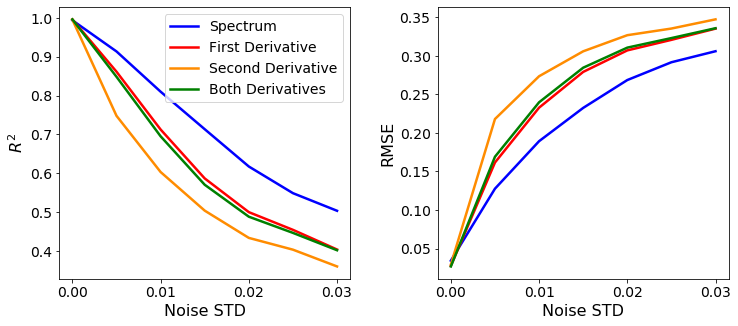

In [9]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(noise_list, spectrum_R2, c='blue', lw=2.5, label='Spectrum')
ax1.plot(noise_list, dmu1_R2, c='red', lw=2.5, label='First Derivative')
ax1.plot(noise_list, dmu2_R2, c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(noise_list, dmu_both_R2, c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Noise STD', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(noise_list, spectrum_RMSE, c='blue', lw=2.5)
ax2.plot(noise_list, dmu1_RMSE, c='red', lw=2.5)
ax2.plot(noise_list, dmu2_RMSE, c='darkorange', lw=2.5)
ax2.plot(noise_list, dmu_both_RMSE, c='green', lw=2.5)
ax2.set_xlabel('Noise STD', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()